In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.collections import LineCollection
import seaborn as sns

import trompy as tp
import csv


colors_restricted = "#219C90"
colors_adlib_light = "#9C89B8" 
colors_adlib_dark = "#0059b3"
colors_sucralose = "#af9991"

In [2]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/stats")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_dark.pickle", 'rb') as handle:
    adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_light.pickle", 'rb') as handle:
    adlib_light = pickle.load(handle)

with open(DATAFOLDER / "adlib_sucralose.pickle", 'rb') as handle:
    adlib_sucralose = pickle.load(handle)

In [3]:
def get_list_of_mice(data):

    mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                        "HL202", "HL205", "HL206", "HL211",
                        "HL301", "HL304", "HL305"]
    
    #"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
    #HL 306, 308 have no virus
    #HL301, HL304, HL305 have poor fiber placement
    #HL313 - HL318 are control mice
    
    list_of_mice = []

    for key, val in adlib_dark.items():
        if val["mouse_ID"] not in list_of_mice and val["mouse_ID"] not in mice_to_exclude:
            list_of_mice.append(val["mouse_ID"])
            
    return list_of_mice

In [10]:
def get_snips(data):
    
    list_of_mice = get_list_of_mice(data)

    snips_mean_start= []
    snips_mean_end = []
    snips_mean_full = []
    
    snips_full = []
    run_lengths = []

    kwargs={"bins":150, "trial_length":15, "baseline_length":5}   

    pre = 5
    post = 10
    mineventlength=8
    binlength=0.1

    for mouse in list_of_mice:
        snips_start = []
        snips_end = []
        snips_full = []

        for key, val in data.items():
            if val["mouse_ID"]==mouse:
                if len(val["licks"]) < 10:
                    continue

                lickdata= tp.lickCalc(val["licks"], minrunlength=3)

                snips_start.append(tp.snipper(val["corrected"], lickdata["rStart"], val["fs"], **kwargs)[0])
                snips_end.append(tp.snipper(val["corrected"], lickdata["rEnd"], val["fs"], **kwargs)[0])

                snipper = tp.Snipper(val["corrected"],
                                        lickdata["rStart"],
                                        end=lickdata["rEnd"],
                                        fs=val["fs"],
                                        pre=pre,
                                        post=post,
                                        binlength=binlength,
                                        zscore=True
                                        )

                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6,2])
                snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
                snips_full.append(snipper.snips)
                plt.plot(snipper.snips.T, color="black", alpha=0.1)
            
                run_lengths_temp = (np.array(lickdata["rEnd"]) - np.array(lickdata["rStart"]))
                run_lengths.append(run_lengths_temp[run_lengths_temp > mineventlength])

        snips_start = np.vstack(snips_start)
        snips_end = np.vstack(snips_end)
        
        try:
            snips_full = np.vstack(snips_full)
            snips_mean_full.append(np.mean(snips_full, axis=0))
            print("adding this mouse")
        except:
            print("no snips to concatenate")

        snips_mean_start.append(np.mean(snips_start, axis=0))
        snips_mean_end.append(np.mean(snips_end, axis=0))
        
        run_lengths = tp.flatten_list(run_lengths)   

    snips_mean_full = np.array(snips_mean_full)
    
    # Normalizing AUC calculations to epoch length
    auc_early_licking = np.trapz(snips_full[:, 50:110], axis=1) / 60 #60 because 6 seconds
    auc_late_licking = np.trapz(snips_full[:, 120:140], axis=1) / 20  #2 seconds
    auc_early_post_licking = np.trapz(snips_full[:, 140:190], axis=1) / 50 # 5 seconds
    auc_late_post_licking = np.trapz(snips_full[:, 190:240], axis=1) / 50 # 5 seconds
    
    return snips_mean_start, snips_mean_end, snips_mean_full, snips_full, pd.DataFrame([run_lengths,
                                    auc_early_licking,
                                    auc_late_licking,
                                    auc_early_post_licking,
                                    auc_late_post_licking],
                                    
                                    index=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"]).T
    

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


adding this mouse
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

<class 'numpy.ndarray'>
Found 2 potential artifacts.
adding this mouse
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

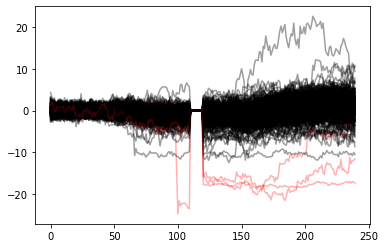

In [11]:
restricted_start, restricted_end, restricted_full, restricted_full_2, restricted_all_aucs = get_snips(restricted_dark)

In [12]:
restricted_all_aucs

,run_lengths,auc_early_licking,auc_late_licking,auc_early_post_licking,auc_late_post_licking
0,50.598216,-1.771928,-2.265716,-0.808113,1.576086
1,39.723336,-0.453736,-0.784339,0.016467,0.912217
2,22.076129,-2.214785,-4.651370,-3.429833,-0.045839
3,10.426122,-2.596142,-3.145698,-3.509233,-2.116127
4,23.459922,-1.178150,-3.307685,-1.774468,-0.023012
5,29.096018,-4.068107,-10.227322,-6.640597,-3.788061
6,10.888151,2.297171,0.883771,3.540995,7.757099
7,32.797000,0.659658,0.328889,1.561682,3.243944
8,14.228029,-0.654393,-1.063009,-3.031997,-1.529102
9,25.998131,-3.046633,-3.181398,-0.687710,2.970947


In [ ]:
def get_aucs(data, mouse):
    
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1

    snips_full = []
    run_lengths = []

    for key, val in data.items():
        if val["mouse_ID"] == mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata = tp.lickCalc(val["licks"], minrunlength=3)

            snipper = tp.Snipper(val["corrected"],
                                 lickdata["rStart"],
                                 end=lickdata["rEnd"],
                                 fs=val["fs"],
                                 pre=pre,
                                 post=post,
                                 binlength=binlength,
                                 zscore=True
                                 )
            
            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6,2])
            snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
            plt.plot(snipper.snips.T, color="black", alpha=0.1)
            snips_full.append(snipper.snips)
            
            print(snipper.snips.shape)
            
            run_lengths_temp = (np.array(lickdata["rEnd"]) - np.array(lickdata["rStart"]))
            run_lengths.append(run_lengths_temp[run_lengths_temp > mineventlength])
        
    try:
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except:
        print("no snips to concatenate")
        
    run_lengths = tp.flatten_list(run_lengths)

    # Normalizing AUC calculations to epoch length
    auc_early_licking = np.trapz(snips_full[:, 50:110], axis=1) / 60 #60 because 6 seconds
    auc_late_licking = np.trapz(snips_full[:, 120:140], axis=1) / 20  #2 seconds
    auc_early_post_licking = np.trapz(snips_full[:, 140:190], axis=1) / 50 # 5 seconds
    auc_late_post_licking = np.trapz(snips_full[:, 190:240], axis=1) / 50 # 5 seconds
    
    return snips_full, pd.DataFrame([run_lengths,
                                    auc_early_licking,
                                    auc_late_licking,
                                    auc_early_post_licking,
                                    auc_late_post_licking],
                                    
                                    index=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"]).T
    

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL203
Run lengths: 18, AUC Snips Full: 18
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL204
Run lengths: 43, AUC Snips Full: 43
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL207
Run lengths: 36, AUC Snips Full: 36
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 2 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Adding snips for mouse HL208
Run lengths: 47, AUC Snips Full: 45
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL209
Run lengths: 41, AUC Snips Full: 41
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL210
Run lengths: 39, AUC Snips Full: 39
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding snips for mouse HL212
Run lengths: 27, AUC Snips Full: 26


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)


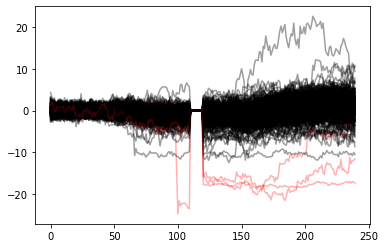